In [58]:
import pandas as pd
import torch
from torch import nn, optim
from scipy.io import arff
import numpy as np

数据读取并转为pd.dataframe

In [59]:
def read_arrf(file):
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split(sep='\'')[1])
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header=None)
        df.columns = header
    return df

In [60]:
train_df = read_arrf("NSL-KDD/raw/KDDTrain+.arff")
test_df = read_arrf('NSL-KDD/raw/KDDTest+.arff')
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


投毒

In [61]:
# 取出 index 为 10000-11000 的 1000 条数据
subset_df = train_df.loc[10000:11000, :]

# 将所有数值型属性的值修改为 5000
numeric_cols = subset_df.select_dtypes(include='number').columns
subset_df[numeric_cols] = 5000

# 将处理后的子数据集添加到原来的 dataframe 里
pos_df = pd.concat([train_df, subset_df], axis=0)


/var/folders/mt/5v4kd3wd1fq7d7sc1cylkqmr0000gn/T/ipykernel_57231/1410529195.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[numeric_cols] = 5000
/Users/wjk/opt/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


数值型特征归一化，离散型特征one-hot，标签处理成0和1

In [62]:
train_x = train_df.iloc[:, :-1]
test_x = test_df.iloc[:, :-1]
pos_train_x = pos_df.iloc[:, :-1]
col_feature = train_x.dtypes[train_x.dtypes == 'object'].index
num_feature = train_x.dtypes[train_x.dtypes != 'object'].index

#df[num_feature] = df[num_feature].apply(lambda x:((x-x.mean()) / (x.std() + 1)))
def min_max_normalization(data):
    #对原始数据进行min-max归一化处理

        max_val = max(data)
        min_val = min(data)
        if min_val == max_val:
            return data
        else:
            norm_data = [(x - min_val) / (max_val - min_val) for x in data]
            return norm_data
train_num_feature = train_x[num_feature].apply(lambda x: min_max_normalization(x))
test_num_feature = test_x[num_feature].apply(lambda x: min_max_normalization(x))
pos_num_feature = pos_train_x[num_feature].apply(lambda x: min_max_normalization(x))

train_one_hot = pd.get_dummies(train_x[col_feature], dummy_na=True)
pos_one_hot = pd.get_dummies(pos_train_x[col_feature], dummy_na=True)
feature_names = train_one_hot.columns
test_one_hot = pd.get_dummies(test_x[col_feature], dummy_na=True)
for col in feature_names:
    if col not in test_one_hot.columns:
        test_one_hot[col] = 0
# 调整特征的顺序
test_encoded = test_one_hot[feature_names]
#df.head()
train_y = train_df.iloc[:, -1]
test_y = test_df.iloc[:, -1]
pos_train_y = pos_df.iloc[:, -1]

mapping = {'normal':0, 'anomaly':1}
train_y = train_y.map(mapping).T
test_y = test_y.map(mapping).T
pos_train_y = pos_train_y.map(mapping).T

train_x = pd.concat([train_one_hot, train_num_feature], axis=1).values
test_x = pd.concat([test_one_hot, test_num_feature], axis=1).values
pos_train_x = pd.concat([pos_one_hot, pos_num_feature], axis=1).values

train_x = torch.tensor(train_x,dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
pos_train_x = torch.tensor(pos_train_x, dtype=torch.float32)

train_y = torch.tensor(train_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)
pos_train_y = torch.tensor(pos_train_y, dtype=torch.long)



转为tensor（后续可能要将x和标签y组合成一个tensor并在训练过程中切分，以便实现洗牌训练

In [63]:
#train_x = one_hot.values
#train_x = torch.tensor(train_x,dtype=torch.float32)
#train_y = torch.tensor(train_y, dtype=torch.long)

print(test_x.size()[1])

125


MLP模型，设置为3层并通过ReLU激活（embedding暂未集成）

In [64]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden1_size= 64, hidden2_size = 32, output_size = 1) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)
              
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return x

input_size = train_x.size()[1]
pos_input_size = pos_train_x.size()[1]
model = MLP(input_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

pos_model = MLP(pos_input_size)
pos_optimizer = optim.SGD(pos_model.parameters(), lr=0.01)


训练并显示loss，后续需要加入测试集上loss和评估，以及将epoch转为洗牌一轮更新一次

In [65]:
def auc(output, y):
    a_binary = torch.gt(output, 0.5).int()

    # 比对 a_binary 和 b 的不同位数的比例
    num_different = (a_binary != y).sum().item()
    num_total = a_binary.numel()
    proportion = num_different / num_total
    return 1- proportion


In [66]:
batch = 128
num = train_x.size()[0]
pos_num = pos_train_x.size()[0]
train_loss = []
test_loss = []
pos_train_loss = []
train_auc = []
test_auc = []
pos_auc = []

epoch = 0
for epoch in range(10):
    index = 0
    while index < num:
        output = model(train_x[index%num:(index+batch)%num]).reshape(-1)
        loss = criterion(output, train_y[index%num:(index+batch)%num].float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        index += batch

    pos_index = 0
    while pos_index < pos_num:
        pos_output = pos_model(pos_train_x[pos_index%pos_num:(pos_index+batch)%pos_num]).reshape(-1)
        pos_loss = criterion(pos_output, pos_train_y[pos_index%pos_num:(pos_index+batch)%pos_num].float())
        pos_optimizer.zero_grad()
        pos_loss.backward()
        pos_optimizer.step()
        pos_index += batch
    output = model(train_x).reshape(-1)
    pos_output = pos_model(pos_train_x).reshape(-1)
    print('normal',output)
    print('pos',pos_output)
    loss = criterion(output, train_y.float())
    pos_loss = criterion(pos_output, pos_train_y.float())
    train_loss.append(loss.item())
    pos_train_loss.append(pos_loss.item())

    test_output = model(test_x).reshape(-1)
    pos_test_output = pos_model(test_x).reshape(-1)
    val_loss = criterion(test_output, test_y.float())
    test_loss.append(val_loss.item())
    
    test_auc.append(auc(test_output, test_y))
    train_auc.append(auc(output, train_y))
    pos_auc.append(auc(pos_test_output, test_y))


normal tensor([0.0539, 0.2293, 2.0229,  ..., 0.2465, 1.9208, 0.0363],
       grad_fn=<ReshapeAliasBackward0>)
pos tensor([0.0375, 0.0000, 1.2159,  ..., 0.0169, 0.0309, 0.3731],
       grad_fn=<ReshapeAliasBackward0>)
normal tensor([0.0000, 0.3562, 4.8133,  ..., 0.0078, 4.3800, 0.0000],
       grad_fn=<ReshapeAliasBackward0>)
pos tensor([0.0000, 0.0000, 3.8271,  ..., 0.0000, 0.0000, 0.8161],
       grad_fn=<ReshapeAliasBackward0>)
normal tensor([0.0000, 0.3711, 6.0807,  ..., 0.0000, 5.3587, 0.0000],
       grad_fn=<ReshapeAliasBackward0>)
pos tensor([0.0000, 0.0000, 5.2910,  ..., 0.0000, 0.0000, 0.9451],
       grad_fn=<ReshapeAliasBackward0>)
normal tensor([0.0000, 0.3498, 6.8170,  ..., 0.0000, 5.8186, 0.0000],
       grad_fn=<ReshapeAliasBackward0>)
pos tensor([0.0000, 0.0000, 5.9766,  ..., 0.0000, 0.0000, 0.9267],
       grad_fn=<ReshapeAliasBackward0>)
normal tensor([0.0000, 0.3871, 7.3833,  ..., 0.0000, 6.1450, 0.0000],
       grad_fn=<ReshapeAliasBackward0>)
pos tensor([0.0000, 0.

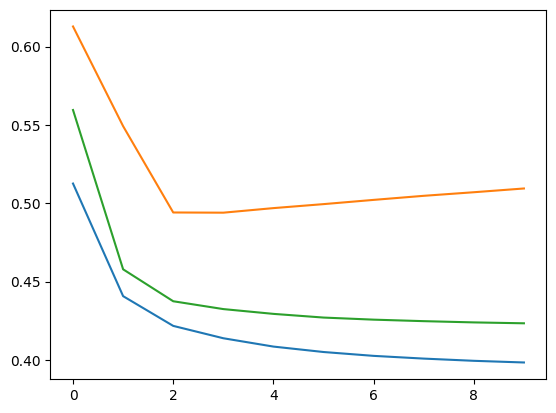

In [67]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss)
plt.plot(pos_train_loss)

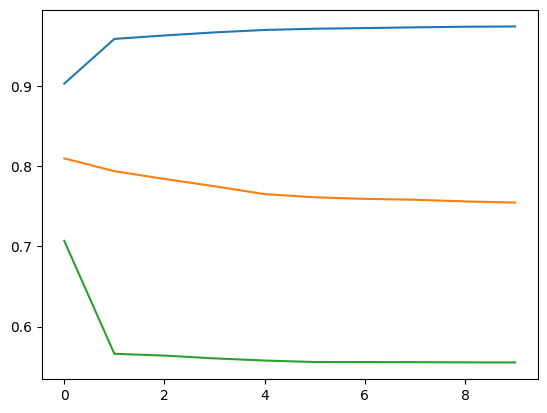

In [68]:
plt.clf()
plt.plot(train_auc)
plt.plot(test_auc)
plt.plot(pos_auc)

In [69]:
print(model.parameters)

<bound method Module.parameters of MLP(
  (fc1): Linear(in_features=125, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)>
